# Barrier Method

In this notebook we want to implement the barrier method. For this we are given a set of functions together with their gradients and Hessians. First you have to fill in the later two.

In [272]:
import numpy as np

In [273]:
import numpy as np

def f0(x):  # log-sum-exp
    return np.log(np.exp(x[0]) + np.exp(x[1]))

def grad0(x):
    Z = np.exp(x[0]) + np.exp(x[1])
    return np.array([np.exp(x[0]) / Z, np.exp(x[1]) / Z])

def H0(x):
    Z = np.exp(x[0]) + np.exp(x[1])
    ex, ey = np.exp(x[0]), np.exp(x[1])
    factor = (ex * ey) / (Z ** 2)
    return np.array([[factor, -factor], [-factor, factor]])

# Quadratic objective (x² + y²)
def f1(x):
    return x[0]**2 + x[1]**2

def grad1(x):
    return 2 * x

def H1(x):
    return 2 * np.eye(2)

# Linear constraint (2x - 3y)
def f2(x):
    return 2 * x[0] - 3 * x[1]

def grad2(x):
    return np.array([2, -3])

def H2(x):
    return np.zeros((2, 2))


Next we collect the functions.

In [274]:
objective = [f0, grad0, H0]
constraints = [[f1, grad1, H1],[f2, grad2, H2]]

print(len(constraints))
b = [5, 0]

2


And lastly we define the interface. You can adapt this if you want to use a different way.

In particular we assume the starting point to be given. When testing you have to first find a feasible point by hand. In the implementation you may assume that there is no linear equality constraint.

In [275]:
def barrier_method(objective, constraints, b, x0, t=1, mu=2, eps=0.001):
    m = len(constraints)

    def phi(x):
        result = 0
        for i in range(m):
            result += np.log(constraints[i][0](x) - b[i])
        return -result

    def grad_phi(x):
        g = np.zeros_like(x, dtype=float)
        for i in range(m):
            denom = constraints[i][0](x) - b[i]
            g += (1 / denom) * constraints[i][1](x)
        return -g

    def hess_phi(x):
        H = np.zeros((len(x), len(x)), dtype=float)
        for i in range(m):
            denom = constraints[i][0](x) - b[i]
            grad_i = constraints[i][1](x)
            #print("qui", grad_i)
            hess_i = constraints[i][2](x)

            if grad_i.shape != (len(x),):
                raise ValueError(f"Constraint {i}: gradient shape is {grad_i.shape}, expected {(len(x),)}")
            if hess_i.shape != (len(x), len(x)):
                raise ValueError(f"Constraint {i}: Hessian shape is {hess_i.shape}, expected {(len(x), len(x))}")

            grad_i = grad_i.reshape(-1, 1)
            H += (1 / denom**2) * (grad_i @ grad_i.T)
            H -= (1 / denom) * hess_i
        return H

    central_path = [x0]
    start = x0

    while t < m / eps:
        def f(x):
            return objective[0](x) + (1 / t) * phi(x)

        def grad(x):
            return objective[1](x) + (1 / t) * grad_phi(x)

        def hessian(x):
            #print(objective[2](x))
            return objective[2](x) + (1 / t) * hess_phi(x)

        point_in_path = newton_desc(f, grad, hessian, start, alpha=0.25, beta=0.5, eps=0.001)
        central_path.append(point_in_path)
        start = point_in_path
        t *= mu

    return np.array(central_path)

You may use the code on gradient descent as a basis for your Newton method. The code we used back then is copied below:

In [276]:
def step_size(x, direction, f, grad, alpha, beta) :
  t = 1
  slope = alpha*np.dot(direction, grad(x))
  while f(x +t*direction) > f(x) + t*slope:
    t = beta * t
  return t

In [277]:
def newton_desc(f, grad, hessian, start, alpha = 0.25, beta = 0.5, eps = 0.001) :
  current = start
  k = 0
  x_values = [start]
  lambda_curr = eps+1
  while lambda_curr**2/2 > eps and k < 1000:
    #print("curr", current)
    #print("hess", hessian(current))
    #print("grad", grad(current))
    direction = -np.linalg.solve(hessian(current), grad(current))
    #print("dir",direction)
    step = step_size(current, direction, f, grad, alpha, beta)
    current = current + step*direction
    x_values.append(current)
    lambda_curr = direction.T@hessian(current)@direction
    k = k + 1
  return np.array(x_values[-1])

Finally test your code below. In particular print the feasibility region and all intermediate solutions. Test different programs formed by the three functions given or even add new functions.

In [278]:
x0 = np.array([1,1])
central_path = barrier_method(objective, constraints, b, x0, t = 1, mu = 2, eps = 0.001)

/var/folders/2c/01bhfspx2hj56fb5ryg654lr0000gn/T/ipykernel_31323/3132777010.py:7: RuntimeWarning: invalid value encountered in log
  result += np.log(constraints[i][0](x) - b[i])


Optimal solution: [-1.86052102 -1.24034735]
Minimum value: -0.8099613460103059


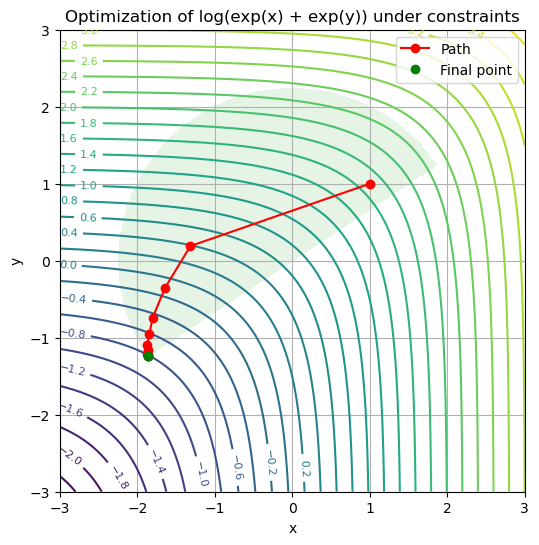

In [279]:


print("Optimal solution:", result.x)
print("Minimum value:", result.fun)

# Convert trajectory to numpy array for plotting
trajectory = np.array(central_path)

# Plotting the feasible region
fig, ax = plt.subplots(figsize=(6, 6))

# Grid for contour
x_vals = np.linspace(-3, 3, 400)
y_vals = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.log(np.exp(X) + np.exp(Y))

# Feasibility mask
mask = ((X**2 + Y**2) <= 5) & ((2 * X - 3 * Y) <= 0)

# Plot objective contours
contours = ax.contour(X, Y, Z, levels=30, cmap='viridis')
ax.clabel(contours, inline=True, fontsize=8)

# Overlay feasibility region
ax.contourf(X, Y, mask, levels=[0.5, 1], colors=['#aaddaa'], alpha=0.3)

# Plot the trajectory
if len(trajectory) > 0:
    ax.plot(trajectory[:, 0], trajectory[:, 1], 'ro-', label='Path')
    ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'go', label='Final point')

# Axes and legend
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Optimization of log(exp(x) + exp(y)) under constraints')
ax.legend()
ax.grid(True)
plt.show()